# ARIMA 모델 기본 사용

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import scipy.stats as stats

from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras_tuner import RandomSearch
from sklearn.model_selection import KFold

In [ ]:
# 엑셀 불러오기
stock_data = pd.read_excel('./tb_stock.xlsx')
samsung_stock = stock_data[['sc_date', 'sc_ss_stock']]
apple_stock = stock_data[['sc_date','sc_ap_stock']]
bitcoin_stock = stock_data[['sc_date','sc_coin']]
samsung_stock['sc_date'] = pd.to_datetime(samsung_stock['sc_date'])
apple_stock['sc_date'] = pd.to_datetime(apple_stock['sc_date'])
bitcoin_stock['sc_date'] = pd.to_datetime(bitcoin_stock['sc_date'])

In [ ]:
# 삼성 주가 그래프
samsung_stock.plot(x='sc_date', y='sc_ss_stock', color='blue')

In [ ]:
# 애플 주가 그래프
apple_stock.plot(x='sc_date', y='sc_ap_stock', color='red')

In [ ]:
# 비트코인 주가 그래프
bitcoin_stock.plot(x='sc_date', y='sc_coin', color='black')

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# acf = 자기 상관함수
# pacf = 편자기상관함수

# 단일 시계열 데이터를 입력으로 사용
# 각 그래프 그리기
plot_acf(samsung_stock['sc_ss_stock'])
plot_pacf(samsung_stock['sc_ss_stock'])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff_1=samsung_stock['sc_ss_stock'].diff(periods=1).iloc[1:] # 이전 값과의 차이(이산)을 구함 (peropds = 비교할 간격)
diff_1.plot() # 차이(이산)을 구한 값을 시각화
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA의 모수는 크게 3가지가 있다. 
# AR모형의 Lag을 의미하는 p 
# MA모형의 Lag을 의미하는 q
# 차분(Diffrence)횟수를 의미하는 d 
# 보통은 p, d, q의 순서로 쓴다.
# 통상적으로 p + q < 2, p * q = 0 인 값들을 많이 사용한다.

# order=(p, d, q) = p = 자동 회귀, d = 차수, q = 이동 평균
# p = 몇 개의 이전 시점 데이터를 사용할 것인지 결정
# d = 안정적인 상태에 도달할 때까지 미분 적용 (보통 0이나 1의 값을 넣음)
# q = 몇 개의 이전 시점의 오차 항을 고려할 것인지 결정

model = ARIMA(samsung_stock['sc_ss_stock'], order=(0, 1, 1))
model_fit = model.fit() # ARIMA 모델에 학습

# summary (모델 학습 결과?)
# AIC(통계 모델을 성능을 측정하는 기준) = 값이 작을 수록 좋음 (보통 AIC의 데이터로 파라미터를 구함)
# BIC(슈바르츠 베이지안 정보 기준) = 값이 작을 수록 좋음
# P>|z|(유의확률) = 값이 0.05보다 작으면 통계적으로 유의미함
# Log Likelihood 클 수록 좋음
print(model_fit.summary())

In [ ]:
# 하이퍼 파라미터 수동 Gridsearch
best_aic = float("inf") # 초기aic값 지정
best_order = None # 초기 order 값 지정

d = 0 # d의 값은 0으로 고정
for p in range(5): # p의 값을 0~4까지
    for q in range(5): # q의 값을 0~4까지
        try:
            model = ARIMA(samsung_stock['sc_ss_stock'], order=(p, d, q))
            model_fit = model.fit()
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = (p, d, q)
        except:
            continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")

In [ ]:
model = ARIMA(samsung_stock['sc_ss_stock'], order=best_order) # 위에서 찾은 best order 값으로 모델 학습
model_fit = model.fit()

print(model_fit.summary()) # 최적의 order값의 summary 정보 확인

In [ ]:
import numpy as np

# 로그 변환
# 로그 변환을 하는 이유(데이터의 분산 안정, 비선형적 추세 제거)
# 데이터의 특성에 따라 제곱근 변환, box-cox변환을 사용할 수 있음
samsung_stock['sc_ss_stock_log'] = np.log(samsung_stock['sc_ss_stock']) 

model = ARIMA(samsung_stock['sc_ss_stock_log'], order=best_order) # 위에서 찾은 best order 값으로 모델 학습
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
samsung_stock_log = samsung_stock.set_index('sc_date') # 삼성 주식 데이터를 sc_date를 기준으로 인덱스화 (시간 인덱스 설정)
samsung_stock_daily = samsung_stock_log.resample('D').mean() # 일별 데이터를 만들기 위해 'D'(day) 단위로 리샘플링하고 평균값으로 결측값을 채움

# 로그 변환
samsung_stock_daily['sc_ss_stock_log'] = np.log(samsung_stock_daily['sc_ss_stock'])

# 최적의 ARIMA 파라미터(best_order)를 사용하여 모델 생성 및 학습
model = ARIMA(samsung_stock_daily['sc_ss_stock_log'], order=(4, 0, 3))  # best_order 사용 가능
model_fit = model.fit()
print(model_fit.summary())

# 예측 (향후 steps일 예측)
forecast = model_fit.get_forecast(steps=3500)
forecast_mean = forecast.predicted_mean # 예측된 평균값 추출
forecast_ci = forecast.conf_int() # 예측 구간(신뢰 구간)을 추출하여 상한과 하한 계산

forecast_mean_exp = np.exp(forecast_mean) # 로그 변환된 예측 값을 원래 스케일로 변환 (지수 변환)
forecast_ci_exp = np.exp(forecast_ci) # 신뢰 구간 원래 스케일로 변환

# 실제 데이터 플롯 시각화
plt.plot(samsung_stock_daily['sc_ss_stock'], label='Observed')

# 예측 값 플롯 시각화
plt.plot(forecast_mean_exp, label='Forecast', color='red')

# 예측 구간(신뢰 구간) 플롯 시각화
plt.fill_between(forecast_ci_exp.index, 
                forecast_ci_exp.iloc[:, 0], # 신뢰 구간 하한
                forecast_ci_exp.iloc[:, 1], # 신뢰 구간 상한
                color='pink', alpha=0.3) # alpha(투명도)

plt.legend() # 플롯에 범례 추가
plt.show()

# p, d, q의 최적값을 찾는 다른 코드

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from tqdm import tqdm

tqdm.pandas()

In [ ]:
# 데이터 불러오기
data = pd.read_excel('./tb_stock.xlsx')[['sc_date', 'sc_ss_stock']]
data.rename(columns={'sc_date' : 'Date', 'sc_ss_stock' : 'Stock'}, inplace=True) # 데이터 컬럼명 지정
data['Date'] = pd.to_datetime(data['Date']) # 날짜 컬럼의 타입 변경(datetime)
data = data.set_index('Date') # 날짜 컬럼을 index로 지정

data.head(1)

In [ ]:
# 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(data['Stock'], label='Samsung Price')
plt.title('Samsung Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# ARIMA 모델 특성상 시계열 데이터가 정상성을 가정하므로 추세를 제거하기 위해 차분(differncing) 수행
# 1차 차분 (Differencing)
diff_close_prices = data['Stock'].diff().dropna()

# 차분된 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(diff_close_prices, label='Differenced Close Price')
plt.title('Differenced Samsung Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.show()

In [ ]:
# ARIMA 모델 학습
model = ARIMA(data['Stock'], order=(5, 1, 0))
model_fit = model.fit()

# 모델 요약 정보 출력
print(model_fit.summary())

In [ ]:
# 미래 주가 예측 (예: 365일 = 1년)
forecast_period = 30
forecast = model_fit.forecast(steps=forecast_period)

# 만약 forecast가 DataFrame이 아닌 Series라면 DataFrame으로 변환하고 날짜 인덱스를 설정
forecast_dates = pd.date_range(start=data.index[-1], periods=len(forecast), freq='D')
forecast = pd.Series(forecast, index=forecast_dates)

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(data['Stock'], label='Historical')
plt.plot(forecast, label='Forecast', color='red')
plt.title('Samsung Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
import itertools
import warnings
warnings.filterwarnings("ignore")

p = d = q = range(0, 3) # p, d, q 변수에 0~2의 값을 지정
pdq = list(itertools.product(p, d, q)) # p, d, q 값들로 만들 수 있는 모든 조합을 생성

best_aic = float('inf')
best_pdq = None

for param in pdq: # 모든 조합 중 최적 값을 찾음
    try:
        model = ARIMA(data['Stock'], order=param)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_pdq = param
    except:
        continue

print(f'Best ARIMA order: {best_pdq} with AIC: {best_aic}')

In [ ]:
# 최적의 pdq 값으로 ARIMA 모델 학습
model = sm.tsa.ARIMA(data['Stock'], order=best_pdq)
results = model.fit()

# 예측 (steps일 미래 예측 예시)
forecast = results.get_forecast(steps=100)
forecast_index = pd.date_range(data.index[-1], periods=100, freq='D')
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# 실제 데이터와 예측 데이터 시각화
plt.figure(figsize=(14, 7))
plt.plot(data['Stock'], label='Historical')
plt.plot(forecast_series, label='Forecast', color='red')
plt.fill_between(forecast_series.index,
                forecast.conf_int().iloc[:, 0],
                forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.title('Samsung Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# for문을 이용하여 특정 기간의 데이터로 예측하는 코드

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from tqdm import tqdm
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

tqdm.pandas()

data = pd.read_excel('./tb_stock.xlsx')[['sc_date', 'sc_ss_stock']]
data.rename(columns={'sc_date' : 'Date', 'sc_ss_stock' : 'Stock'}, inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

predict_list = [] # 학습된 데이터를 모으는 리스트
date = 7          # 모델 학습 시 예측할 기간
for i in tqdm(range(20, len(data)-date, date)) : # 20일부터 데이터 길이 -date 까지 반복하는 for문
  # ARIMA 모델 학습
  model = ARIMA(data[i:i+date], order=(2, 1, 2)) 
  model_fit = model.fit()

  # 미래 주가 예측
  forecast_period = date
  forecast = model_fit.forecast(steps=forecast_period)
  # 만약 forecast가 DataFrame이 아닌 Series라면 DataFrame으로 변환하고 날짜 인덱스를 설정
  forecast_dates = pd.date_range(start=data.index[i+date], periods=forecast_period, freq='D')
  forecast_series = pd.Series(forecast, index=forecast_dates)
  
  # 예측 결과를 리스트에 추가
  predict_list.append(forecast_series)

# predict_list의 형태가 [ [1,2,3], [4,5,6] ]인 중첩리스트 형태이므로 concat을 이용하여 하나의 리스트(Series)로 변경
series_list = pd.concat(predict_list)

100%|██████████| 514/514 [00:50<00:00, 10.26it/s]


In [8]:
# 기존 리스트 초기화 및 합쳐진 리스트를 저장
predict_list = [series_list]

# 새로운 예측을 수행하는 반복문
for i in tqdm(range(500)): # 몇번 반복을 진행할지 (forecast_period * range 일 예측)
    # 마지막 [-30:]일의 데이터를 가지고 예측을 진행
    model = ARIMA(predict_list[-1][-30:], order=(2, 1, 2))
    model_fit = model.fit()

    # 새로운 (forecast_period)일 예측
    forecast_period = 1
    forecast = model_fit.forecast(steps=forecast_period)

    # 예측 날짜 인덱스 설정
    forecast_dates = pd.date_range(start=predict_list[-1].index[-1], periods=forecast_period+1, freq='D')[1:]
    forecast_series = pd.Series(forecast, index=forecast_dates)

    # 예측 결과를 기존 시계열에 추가
    predict_list.append(forecast_series)

# 최종 예측 시계열을 병합하여 전체 시계열로 생성
final_forecast = pd.concat(predict_list)

100%|██████████| 500/500 [00:06<00:00, 76.63it/s]


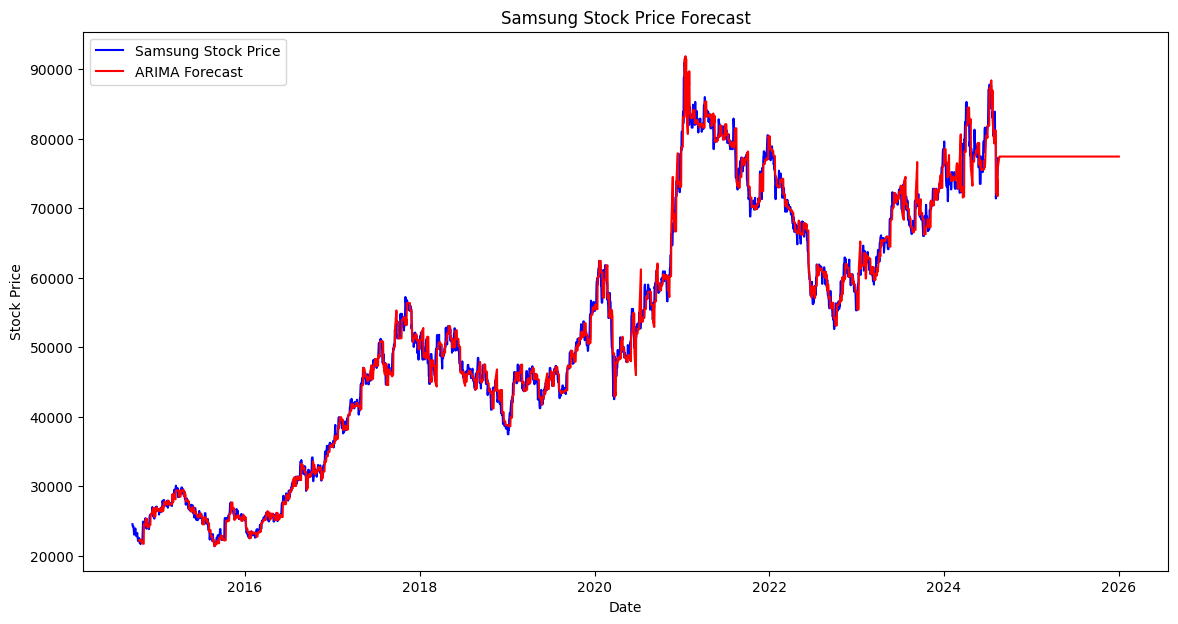

In [9]:
# 예측 결과를 하나의 데이터프레임으로 합치기
all_forecasts = pd.concat(predict_list)

plt.figure(figsize=(14, 7))
plt.plot(data['Stock'], label='Samsung Stock Price', color='blue')
plt.plot(final_forecast, label='ARIMA Forecast', color='red')
plt.title('Samsung Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [302]:
import numpy as np
# 로그 변환을 되돌리기 (필요한 경우)
final_forecast_exp = np.exp(final_forecast)
data_exp = np.exp(all_forecasts)

# 로그 변환 전에 0 또는 음수 값을 대체
final_forecast[final_forecast <= 0] = np.nan
all_forecasts[all_forecasts <= 0] = np.nan

# 로그 변환
final_forecast_exp = np.exp(final_forecast.dropna())
all_forecasts_exp = np.exp(all_forecasts.dropna())

final_forecast_exp = final_forecast_exp.replace([np.inf, -np.inf], np.nan).dropna()
all_forecasts_exp = all_forecasts_exp.replace([np.inf, -np.inf], np.nan).dropna()

# R² 계산
actual_values = all_forecasts_exp[-len(final_forecast_exp):]  # 실제 값
predicted_values = final_forecast_exp  # 예측 값

r2 = r2_score(actual_values, predicted_values)
print(f"R² Score: {r2}")

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.